## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import cv2
import random
import pandas as pd
import matplotlib.image as mpimg
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import load_model
from keras.models import Sequential
from keras.layers import Lambda, Dense, Flatten, Dropout
from keras.layers import Convolution2D, ELU
from keras.regularizers import l2
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# constants
SIZE = 128
BATCH_SIZE = 64

In [3]:
# read csv logs
rows = pd.read_csv('datalog_train.csv')
angles = rows['angle'].tolist()
samples = rows['image'].tolist()
print("Number of training samples: ", len(angles))

Number of training samples:  2600


In [4]:
# split
shuffle(samples, angles)
imgs_train, imgs_valid, angles_train, angles_valid = train_test_split(samples, angles, test_size=0.3)

In [5]:
# data preprocessing pipeline
def random_shift(img):
    if random.randint(0, 1) == 0:
        return img
    h, w, c = img.shape
    shape = (w, h)
    M = np.float32([[1, 0, random.randint(-SIZE // 7, SIZE // 7)],
                    [0, 1, random.randint(-SIZE // 9, SIZE // 9)]])
    return cv2.warpAffine(img, M, shape)

def flip(img, angle):
    if random.randint(0, 1) == 0:
        return img, angle
    img = np.fliplr(img)
    angle = -angle
    return img, angle

In [6]:
# generators
def train_generator(batch_size):
    while True:  # Loop forever so the generator never terminates
        shuffle(imgs_train, angles_train)
        batch_imgs = []
        batch_angles = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs_train)-1)
            angle = angles_train[random_index] * (1 + random.uniform(-0.1, 0.1)) # add noise
            img = mpimg.imread(imgs_train[random_index])
            img = random_shift(img)
            img, angle = flip(img, angle)
            batch_imgs.append(img)
            batch_angles.append(angle)
        yield (np.array(batch_imgs), np.array(batch_angles))


def valid_generator(batch_size):
    while True:  # Loop forever so the generator never terminates
        shuffle(imgs_valid, angles_valid)
        batch_imgs = []
        batch_angles = []
        for i in range(batch_size):
            random_index = random.randint(0,len(imgs_valid)-1)
            angle = angles_train[random_index]
            img = mpimg.imread(imgs_valid[random_index])
            batch_imgs.append(img)
            batch_angles.append(angle)
        yield (np.array(batch_imgs), np.array(batch_angles))

# generate
generator_train = train_generator(BATCH_SIZE)
generator_valid = valid_generator(BATCH_SIZE)

In [7]:
# parameters
samples_per_epoch = (len(imgs_train) // BATCH_SIZE) * BATCH_SIZE
shape = (SIZE, SIZE, 3)

In [8]:
# network architecture
def guess_angle():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 250) - 0.5, input_shape=shape))

    model.add(Convolution2D(24, 5, 5, init='he_normal', subsample=(2, 2), 
                            border_mode='valid', W_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ELU())

    model.add(Convolution2D(32, 5, 5, init='he_normal', subsample=(2, 2), 
                            border_mode='valid', W_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ELU())

    model.add(Convolution2D(48, 5, 5, init='he_normal', subsample=(2, 2), 
                            border_mode='valid', W_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ELU())

    model.add(Convolution2D(64, 3, 3, init='he_normal', subsample=(1, 1), 
                            border_mode='valid', W_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ELU())

    model.add(Convolution2D(128, 3, 3, init='he_normal', subsample=(1, 1), 
                            border_mode='valid', W_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(ELU())

    model.add(Flatten())

    model.add(Dense(256, init='he_normal'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(0.8))

    model.add(Dense(128, init='he_normal'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(0.8))

    model.add(Dense(32, init='he_normal'))
    model.add(BatchNormalization())
    model.add(ELU())
    model.add(Dropout(0.4))

    model.add(Dense(1))
    return model

In [18]:
model = guess_angle()

# train and save
adam = Adam(lr=0.001)

import keras.backend as K
def scheduler(epoch):
    if epoch == 0:
        print("learning rate:", K.get_value(model.optimizer.lr))
    if (epoch+1) % 10 == 0:
        rate = K.get_value(model.optimizer.lr)
        K.set_value(model.optimizer.lr, rate * 0.3)
        print("learning rate:", K.get_value(model.optimizer.lr))
    return K.get_value(model.optimizer.lr)

learning_rate_decay = LearningRateScheduler(scheduler)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('model_b.h5', monitor='val_loss', save_best_only=True)

model.compile(loss='mse', optimizer=adam)
model.summary()

history = model.fit_generator(generator_train,
                    samples_per_epoch=samples_per_epoch*2,
                    validation_data=generator_valid,
                    nb_val_samples=len(imgs_valid),
                    nb_epoch=40, 
                    callbacks=[checkpoint, early_stop, learning_rate_decay])

model.save('model_b.h5')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_3 (Lambda)                (None, 128, 128, 3)   0           lambda_input_6[0][0]             
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 62, 62, 24)    1824        lambda_3[0][0]                   
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorm (None, 62, 62, 24)    96          convolution2d_11[0][0]           
____________________________________________________________________________________________________
elu_17 (ELU)                     (None, 62, 62, 24)    0           batchnormalization_17[0][0]      
___________________________________________________________________________________________

3584/3584 [==============================] - 5s - loss: 3.9019 - val_loss: 73.3476
Epoch 18/40
3584/3584 [==============================] - 5s - loss: 3.7746 - val_loss: 92.1091
Epoch 19/40
3584/3584 [==============================] - 5s - loss: 3.8807 - val_loss: 72.7854
learning rate: 9e-05
Epoch 20/40
3584/3584 [==============================] - 5s - loss: 3.5604 - val_loss: 70.0422
Epoch 21/40
3584/3584 [==============================] - 5s - loss: 3.8162 - val_loss: 67.9089
Epoch 22/40
3584/3584 [==============================] - 5s - loss: 3.6768 - val_loss: 76.5958
Epoch 23/40
3584/3584 [==============================] - 5s - loss: 3.6321 - val_loss: 67.2661
Epoch 24/40
3584/3584 [==============================] - 5s - loss: 3.5980 - val_loss: 77.7549
Epoch 25/40
3584/3584 [==============================] - 5s - loss: 3.5620 - val_loss: 69.4454
Epoch 26/40
3584/3584 [==============================] - 5s - loss: 3.6128 - val_loss: 68.7541
Epoch 27/40
3584/3584 [==================

## Evaluate model

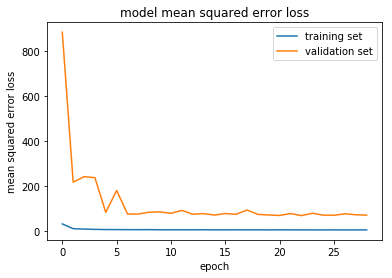

In [19]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [14]:
# read csv logs
rows_test = pd.read_csv('datalog_test.csv')
angles_test = rows_test['angle'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  500


In [10]:
# evaluate on test data
img_test = []
ang_test = []
for i in range(len(samples_test)-1):
    angle = angles_test[i]
    img = mpimg.imread(samples_test[i])
    img_test.append(img)
    ang_test.append(angle)
    
# evaluate
model = load_model('model_b.h5')

score = model.evaluate(np.array(img_test), np.array(ang_test), verbose=0)
print("Average accuracy: {0:.2f}%".format(100 - score))

Average accuracy: 99.08%


Actual angle:  -8


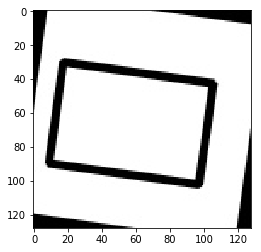

In [11]:
# example: one test image that we want to correct
random.seed(10)
random_index = random.randint(0,len(samples_test)-1)
angle = angles_test[random_index]
img = mpimg.imread(samples_test[random_index])
plt.imshow(img)
print("Actual angle: ", angle)

In [12]:
# predict angle
image_array = np.asarray(img)
ang = float(model.predict(image_array[None, :, :, :], batch_size=1))
print("Predicted angle: ", ang)

Predicted angle:  -7.826287269592285


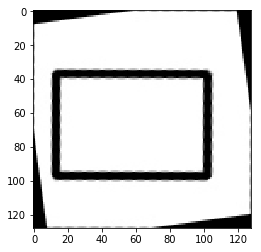

In [13]:
# angle correction
height, width, ch = img.shape
sh = (width, height)
center = (width // 2, height // 2)
M = cv2.getRotationMatrix2D(center, -ang, 1.0)
result = cv2.warpAffine(img, M, sh)
plt.imshow(result)
plt.show()